In [23]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from rikabplotlib.plot_utils import newplot

import torch
import zuko

In [24]:
# Physics Parameters
E0 = 500
R = 0.4



# Training Params
MODE = "UNIFORM_SAMPLES" #"UNIFORM_SAMPLES"

# LOSS = "FORWARD"
# LOSS = "REVERSE"
LOSS = "logMSE"
# LOSS = "ratioMSE"

DEBUG = True

epochs = 1250*2
batch_size = 512*4
lr = 1e-3
auxiliary_params = 1 # Number of auxiliary parameters to use in the model, 0 has different behavior!
num_transforms = 3 # I think this is the number of layers?
hidden_features=(32, 32)
x_range = (0, 1) # Range of x values to train on, should be at least as large as the support of the data


In [25]:
# Distribution Choices:

def Gaussian(x):

    mean = 0
    std = 1

    # Gaussian 
    p = 1/np.sqrt(2 * np.pi  * std**2) * np.exp(- (x - mean)**2 / 2 / std**2)
    return p

def Uniform(x): 

    return Theta(x) * Theta(1 - x)


def Theta(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def dalpha_dscale(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return -4 * np.pi / beta_0  / (torch.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale

def LO_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -torch.nan_to_num(((2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * torch.log(lambda_ ) / lambda_ * Theta(1 - lambda_)) )* Theta(lambda_)* Theta(1-lambda_)



def df_dx(lambda_, beta = 1):

    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3

    scale = E0 * torch.pow(lambda_, 1 / (beta))
    alpha_s_scale = alpha_s(scale)

    C_F = 4/3


    dLO_dalpha =  -C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)
    dalpha_dscale = -4 * np.pi / beta_0  / (torch.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale
    dscale_dlambda = E0

    return dLO_dalpha * dalpha_dscale * dscale_dlambda

   

def LL_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    p = torch.nan_to_num(LO_angularity(lambda_, beta) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) )

    return (p * Theta(lambda_) * Theta(1 - lambda_))



def LL_exact_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    p = torch.nan_to_num((LO_angularity(lambda_, beta) + df_dx(lambda_, beta)) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) )

    return  (p * Theta(lambda_) * Theta(1 - lambda_)) * 1


# Choice of target
target_p = LO_angularity

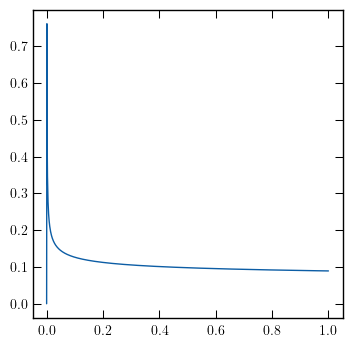

In [26]:
# plot the derivative dLO_dx
x = np.linspace(0, 1, 1000)
plt.plot(x, alpha_s(E0 * torch.tensor(x)).detach().numpy())


0.8214622884981979
0.9999998162831474


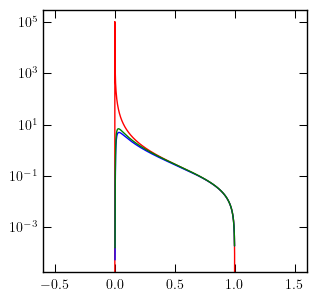

In [27]:
# Plot the target distribution

fig, ax = newplot("column")

xs = np.linspace(-0.5, 1.5, 1000)
ys = target_p(torch.tensor(xs)).detach().numpy()
ax.plot(xs, ys, label="LL Angularity", color = "red")

plt.yscale("log")

# Plot the LL and LL_exact distributions
xs = np.linspace(0.002, 0.999, 1000)
ys = LL_angularity(torch.tensor(xs)).detach().numpy()
print(np.trapz(ys, xs))
ax.plot(xs, ys, label="LL Angularity", color = "blue")

ys = LL_exact_angularity(torch.tensor(xs)).detach().numpy()
print(np.trapz(ys, xs))
ax.plot(xs, ys, label="LL Exact Angularity", color = "green")




In [28]:
import torch
from torch import Tensor
from torch.distributions import constraints
from zuko.transforms import Transform


class AffineSigmoid(Transform):
    r"""
    Affine Sigmoid transformation that maps from real numbers to the interval (a, b).

    Arguments:
        a (float): The lower bound of the interval.
        b (float): The upper bound of the interval.
    """

    bijective = True

    def __init__(self, a: float, b: float, **kwargs):
        super().__init__(**kwargs)
        self.a = a
        self.b = b
        self.domain = constraints.real
        self.codomain = constraints.interval(a, b)

    def _call(self, x: Tensor) -> Tensor:
        # Forward transformation: x in R -> y in (a, b)
        s = torch.sigmoid(x)
        y = self.a + (self.b - self.a) * s
        return y

    def _inverse(self, y: Tensor) -> Tensor:
        # Inverse transformation: y in (a, b) -> x in R
        s = (y - self.a) / (self.b - self.a)
        x = torch.log(s) - torch.log1p(-s)
        return x

    def log_abs_det_jacobian(self, x: Tensor, y: Tensor) -> Tensor:
        # Log absolute determinant of the Jacobian
        sigma_x = torch.sigmoid(x)
        log_det = torch.log(self.b - self.a) + torch.log(sigma_x) + torch.log1p(-sigma_x)
        return log_det

In [29]:
from zuko.distributions import DiagNormal
from zuko.flows import UnconditionalDistribution

# Initialize the flow

# Can choose: NSF, MAF, NICE
flow = zuko.flows.NSF(features = auxiliary_params + 1, context=1, transforms= num_transforms, hidden_features=hidden_features)

# # Hack to make the flow bounded between 0 and 1
# flow = zuko.flows.Flow(transform = [flow, AffineSigmoid(0,1)], base =UnconditionalDistribution(
#         DiagNormal,
#         torch.zeros(3),
#         torch.ones(3),
#         buffer=True,
#     ),)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def inverse_sigmoid(x):
    return torch.log(x / (1 - x))

def log_abs_det_jacobian_sigmoid(x,):
    sigma = sigmoid(x)
    return torch.abs(torch.log(sigma) + torch.log(1 - sigma))

def counting_parameter(x, C = 1):
    return C * alpha_s(E0 * x) * torch.log(1/x) / x 


print(flow)

# print list of all attributes of the flow
print(flow.__dict__.keys())

optimizer = torch.optim.Adam(flow.parameters(), lr=lr)


pytorch_total_params = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(f"Numb. trainable params: {pytorch_total_params}")


NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=3, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=3, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_featur

In [30]:
# Training Loop

PLOT_EACH_EPOCH = False
t = tqdm(range(epochs))
losses = []
training_cs = []
logps = []
logqs = []
logJs = []
xss = []

for epoch in t:

    # Generate a random cutoff c
    c = torch.rand(1) * (x_range[1] - x_range[0]) + x_range[0]
    
    # # Don't let c get too close to 0 at first
    # if epoch < epochs / 2:
    #     c = 1 -  c * epoch / (epochs / 2)


    if MODE == "GENERATED_SAMPLES":



        xs = sigmoid(flow(c).sample((batch_size,)))
        logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
        logq = flow(c).log_prob(inverse_sigmoid(xs)) + logJ
        logp = torch.nan_to_num(torch.log(target_p(xs))[:,0])

        if LOSS == "FORWARD":
            raise NotImplementedError("Impossible to do a forward KL loss with generated samples!")

        # Can only do reverse
        loss = torch.nanmean(Theta(xs[:,0] - c) * (logq - logp))

    

    # Used to be called "REVERSE" / "No samples"
    if MODE == "UNIFORM_SAMPLES":

        reroll = True

        while reroll:
            xs = torch.rand(batch_size, auxiliary_params + 1)  * (x_range[1] - x_range[0]) + x_range[0]
            # xs[:,0] = xs[:,0] * (1 - c) + c
            # xs = torch.zeros(batch_size, auxiliary_params + 1) 
            # xs[:,0] = torch.linspace(0.001, 0.999, batch_size)

            # Auxillary variable -- uniform. alternatively set to const
            if auxiliary_params > 0:
                xs[:,1:] = torch.rand(batch_size, auxiliary_params)
                # xs[:,1] = torch.linspace(0.001, 0.999, batch_size)

            # Check if any x are 0 or 1 to float point error, reroll if so
            if torch.any(xs == 0) or torch.any(xs == 1):
                reroll = True
            else:
                reroll = False

        # Note for log_prob to work, we need to pass a tensor of shape (batch_size, >=1)
        logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
        logq = (((flow(c).log_prob(inverse_sigmoid(xs)) + logJ)))
        logp = torch.nan_to_num(torch.log(target_p(xs))[:,0])
        # technically need to adjust logp if aux is anything other than U(0,1)

        # Bou
        allowed_error = counting_parameter(xs[:,0], C = 1) ** 1
        # loss = torch.nanmean(Theta(xs[:,0] - c)  * (logp - logq)**2 ) 

        # For forward, do plog(p/q), for reverse do qlog(q/p)

        norm_p = torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logp)) 
        norm_q = torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logq)) 

        logp_prime = logp - torch.nan_to_num(1*torch.log(norm_p))
        logq_prime = logq - torch.nan_to_num(1*torch.log(norm_q))


        if LOSS == "FORWARD":
            loss = torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logp_prime) * (logp_prime - logq_prime ))

        if LOSS == "REVERSE":
            loss = torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logq_prime) * (logq_prime - logp_prime ))

        if LOSS == "logMSE":
            C = Theta(xs[:,0] - c)
            loss = torch.nanmean(Theta(xs[:,0] - c) * (logp - logq)**2 )

        if LOSS == "ratioMSE":
            C = Theta(xs[:,0] - c)
            C = allowed_error 
            loss = torch.nanmean(C * (1 - torch.exp(logq) / torch.exp(logp))**2 )

        if DEBUG:
            # print(f"Loss: {loss.item()}")
            # print(f"c: {c.item()}")
            # print(f"Norm p: {norm_p.item()}, Total p: {torch.nanmean(torch.exp(logp)).item()}")
            # print(f"Norm q: {norm_q.item()}, Total q: {torch.nanmean(torch.exp(logq)).item()}")
            # print(f"Mearn norm error: {torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logp_prime) * torch.log(norm_q / norm_p)).item()}")
            # print(f"Mean error: {torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logp_prime) * (logp - logq)).item()}")
            # print(f"logp: {logp[:5]}")
            # print(f"logq: {logq[:5]}")
            # print()

            logps.append(logp)
            logqs.append(logq)
            logJs.append(logJ)
            xss.append(xs)
            

    loss.backward()

    if PLOT_EACH_EPOCH:
        if epoch % 1 == 0:
            fig, ax = newplot("column")

            ys = torch.exp(logp).detach().numpy()
            ax.scatter(xs[:,0], ys, label="Target", color = "red")

            ys = torch.exp(logq).detach().numpy()
            ax.scatter(xs[:,0], ys, label="Flow", color = "blue")
            plt.yscale("log")   
            plt.legend()

            plt.show()


    # Gradient Descent
    optimizer.step()
    optimizer.zero_grad()


    training_cs.append(c.item())
    losses.append(loss.item())
    t.set_description(f"Loss: {loss.item()}")



  0%|          | 0/2500 [00:00<?, ?it/s]

Loss: 3.449986457824707:  72%|███████▏  | 1809/2500 [03:52<01:28,  7.77it/s]  


KeyboardInterrupt: 

[0.370139   0.40979654 0.17097998 ... 0.45366216 0.48110843 0.42839843]


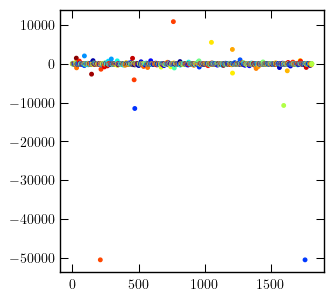

In [31]:
fig, ax = newplot("column")

cmap = plt.get_cmap("jet")

losses = np.array(losses)
training_cs = np.array(training_cs)
print(training_cs)

ax.scatter(np.arange(len(losses)), losses, c = 1-training_cs[:len(training_cs)], cmap = cmap)
# plt.yscale("log")

In [12]:
# start_index = 957

# print("Losses:", losses[start_index:960])

# print("logp:",logps[start_index:960])

# print("logq:",logqs[start_index:960])

# print("xs:",xss[start_index:960])

# print("cs:",training_cs[start_index:960])




# def mse(x, y, xs, cs):
#     return torch.nanmean(Theta(xs[:,0] - cs) * (x - y)**2)

# for i in [start_index, start_index + 1, start_index + 2, start_index + 3]:
#     print("MSE:", [mse(logps[i], logqs[i], xss[i], training_cs[i])])

# # Print the whole array, not just ...
# culprit_p = logps[958].detach().numpy()
# culprit_q = logqs[958].detach().numpy()

# print(culprit_p.mean(), culprit_q.mean())
# for i in range(0, len(culprit_p)):
#     print(i, culprit_p[i], culprit_q[i])

# culprit_index = 1681
# print(xss[958][culprit_index - 1 : culprit_index + 2])
# print(logJ[958])


/tmp/ipykernel_238674/1347371535.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Cutoff")


Text(0, 0.5, 'Aux 0')

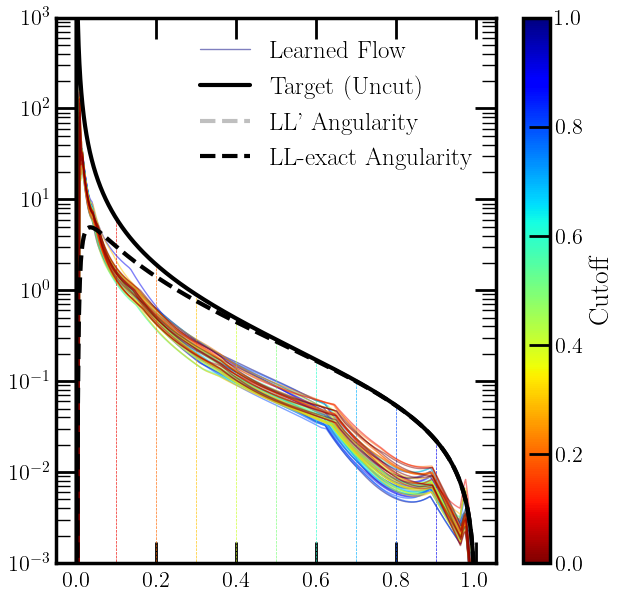

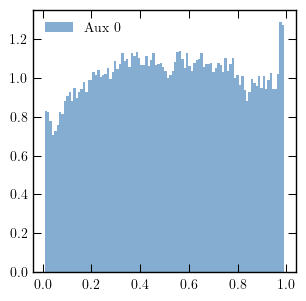

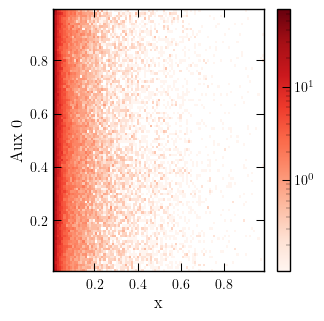

In [32]:
# Plot distribution of xs

fig, ax = newplot("full")
cs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999][::-1]
# cs = [0.5]

DRAW_NF_HIST = False
DRAW_NF_LINES = True
aux_draws = 5


for i in range(len(cs)):


    # Draw hist
    c = torch.tensor((cs[i],))

    if DRAW_NF_HIST:
        samples = sigmoid(flow(c).sample((100000,)))
        x_samples = samples[:,0].detach().numpy()
        aux_samples = samples[:,1:].detach().numpy()

        jet_color = plt.get_cmap("jet")(  i / 10)
        if i == 0:
            label = "Generated Samples"
        else:
            label = None
        ax.hist(x_samples, bins=100, density=True, color = jet_color, alpha = 0.5, label = label, histtype="step")

    if DRAW_NF_LINES:

        for aux_draw in range(aux_draws):
            xs = torch.rand(10000, auxiliary_params + 1) * (x_range[1] - x_range[0]) + x_range[0]
            
            # Sort the first column
            xs = xs[torch.argsort(xs[:,0])]
            xs[:,1:] = torch.rand(1) * torch.ones((10000, auxiliary_params))
            

            logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
            ys = (flow(c).log_prob(inverse_sigmoid(xs)) + logJ).exp()

            xs = xs[:,0].detach().numpy().flatten()
            ys = np.nan_to_num(ys.detach().numpy().flatten())

            jet_color = plt.get_cmap("jet")( i / 10)
            if i == 0 and aux_draw == 0:
                label = "Learned Flow"
            else:
                label = None

            ax.plot(xs, ys, color = jet_color, lw = 1, alpha = 0.5, label = label)

            ax.vlines(cs[i], 0, target_p(c), color = jet_color, linestyle = "--", alpha = 0.25, lw = 0.5)



# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("jet_r"), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, label="Cutoff")




# c = torch.tensor((0.5,))
# xs = torch.zeros((10000, auxiliary_params + 1)) + 0.5
# xs[:,0] = torch.linspace(0.001, 0.999, 10000)
# logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
# ys = (flow(c).log_prob(inverse_sigmoid(xs)) + logJ).exp()

# print(flow(c).log_prob(inverse_sigmoid(xs)))
# print(ys)

# xs = xs[:,0].detach().numpy().flatten()
# ys = np.nan_to_num(ys.detach().numpy().flatten())
# ps = target_p(torch.tensor(xs)).detach().numpy().flatten()
# plt.plot(xs, ys, color = "red", label = "Learned Flow")
# print(ys.mean())

# c = c.detach().numpy()

cutoff = xs > 0.5

plt.plot(xs, target_p(torch.tensor(xs)), color = "Black", label = "Target (Uncut)")
plt.plot(xs, LL_angularity(torch.tensor(xs)), color = "black", linestyle = "--", label = "LL' Angularity", alpha = 0.25)
plt.plot(xs, LL_angularity(torch.tensor(xs)), color = "black", linestyle = "--", label = "LL-exact Angularity")


# cutoff_norm = np.trapz(ps * cutoff, xs)
# plt.plot(xs, cutoff * ps , color = "grey", label = rf"Target (Cut at $c$ = {cs[0]})")

plt.legend()

plt.yscale("log")

plt.ylim(1e-3, 1e3)

c = torch.tensor((0.5,))
samples = sigmoid(flow(c).sample((100000,)))
x_samples = samples[:,0].detach().numpy()
aux_samples = samples[:,1:].detach().numpy()


# plot the auxiliary variables
if auxiliary_params > 0:
    fig, ax = newplot("column")
    for i in range(auxiliary_params):
        plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
        prob = flow(c).log_prob(samples).exp()
        # plt.scatter(aux_samples[:,i], prob.detach().numpy(), color = "red")
    plt.legend()

# correlation between auxiliary variable 1 and x
import matplotlib as mpl
fig, ax = newplot("column")
bar = ax.hist2d(x_samples, aux_samples[:,0], bins=100, density=True, norm=mpl.colors.LogNorm(), cmap="Reds")
plt.colorbar(bar[3])
plt.xlabel("x")
plt.ylabel("Aux 0")



In [23]:
# #  Plot distribution of xs


# samples = flow().sample((100000,)).detach().numpy()
# x_samples = samples[:,0]
# aux_samples = samples[:,1:]

# fig, ax = newplot("column")

# plt.hist(x_samples, bins=100, density=True, color = "red", alpha = 0.5)


# xs = torch.zeros((1000, auxiliary_params + 1))
# xs[:,0] = torch.linspace(-0.5, 1.5, 1000)
# ys = flow().log_prob(xs).exp()

# xs = xs[:,0].detach().numpy().flatten()
# ys = ys.detach().numpy().flatten()
# plt.plot(xs, ys, color = "red")


# plt.plot(xs, target_p(torch.tensor(xs)), color = "blue")

# plt.yscale("log")

# # plot the auxiliary variables
# if auxiliary_params > 0:
#     fig, ax = newplot("column")
#     for i in range(auxiliary_params):
#         plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
#         plt.plot(xs, ys, color = "red")
#     plt.legend()
